In [1]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB
from gurobipy import quicksum
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from tqdm import tqdm
sns.set(style ="whitegrid", font_scale=1.5)
import sys
import os
import pickle
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from model.schedule import ScheduleGenerator
from model.topology import *

from matplotlib.ticker import MultipleLocator
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
custom_colors = ["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)
color_palette = np.array(["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"])
matplotlib.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})
# os.environ['GRB_LICENSE_FILE'] = '/home/albert/gurobipy/gurobi.lic'

## Demand File Processing & Viz

In [2]:
import model.NetworkUtils
importlib.reload(model.NetworkUtils)
from model.NetworkUtils import * 

#### Basic Demand Processing

In [3]:
np.random.seed(9)
gen = ScheduleGenerator('../data/LAX_ind.csv', '../data/T_F41SCHEDULE_B43.csv')
schedule, pax_arrival_times, num_pax_per_flight = gen.get_one_day(8, 1, directional_demand=5000)
vertiports = ['LAX', 'DTLA', 'LGB', 'WDHL', 'UVS', 'ANH', 'HWD', 'PSD', 'BVH']
vertiport_dict = {idx: i for idx, i in enumerate(vertiports)}
schedule['schedule'] = np.ceil(schedule['schedule']/5)
schedule = schedule.groupby(['schedule', 'od']).size().reset_index(name='count')
apt_dt = schedule[schedule['od'] == 'LAX_DTLA'].reset_index(drop=True)
dt_apt = schedule[schedule['od'] == 'DTLA_LAX'].reset_index(drop=True)

#### Demand Distribution

In [4]:
# Uniform distribution
p = np.repeat(1,len(vertiports)-1) / (len(vertiports)-1)
np.random.seed(9)
demand_dict, flight_count = get_demand_dict(apt_dt, dt_apt, p.cumsum(), vertiports)

# Distribution from https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9441659
p_2 = np.array([6.1, 3.3, 1.5, 1.5, 5.4, 4.3, 2.5, 2.2])
p_2 = p_2 / p_2.sum()
np.random.seed(9)
demand_dict_2, flight_count_2 = get_demand_dict(apt_dt, dt_apt, p_2.cumsum(), vertiports)

# Distribution with epislon
p_3 = modify_demand_dist(p_2, epsilon = 0.5)
np.random.seed(9)
demand_dict_3, flight_count_3 = get_demand_dict(apt_dt, dt_apt, p_3.cumsum(), vertiports)

#### Visualization

In [5]:
demand_dict_to_plot = demand_dict_3
flight_count_to_plot = flight_count_3

In [6]:
demand_arr_for_viz = np.zeros(shape=(2, len(vertiports), 24))
for key, value in demand_dict_to_plot.items():
    origin, destination, time = key
    time_key = (time-1) // 12
    if origin == 0:
        demand_arr_for_viz[0, destination, time_key] += value
    elif destination == 0:
        demand_arr_for_viz[1, origin, time_key] += value
realized_p = flight_count_to_plot[1:]/flight_count_to_plot[1:].sum()

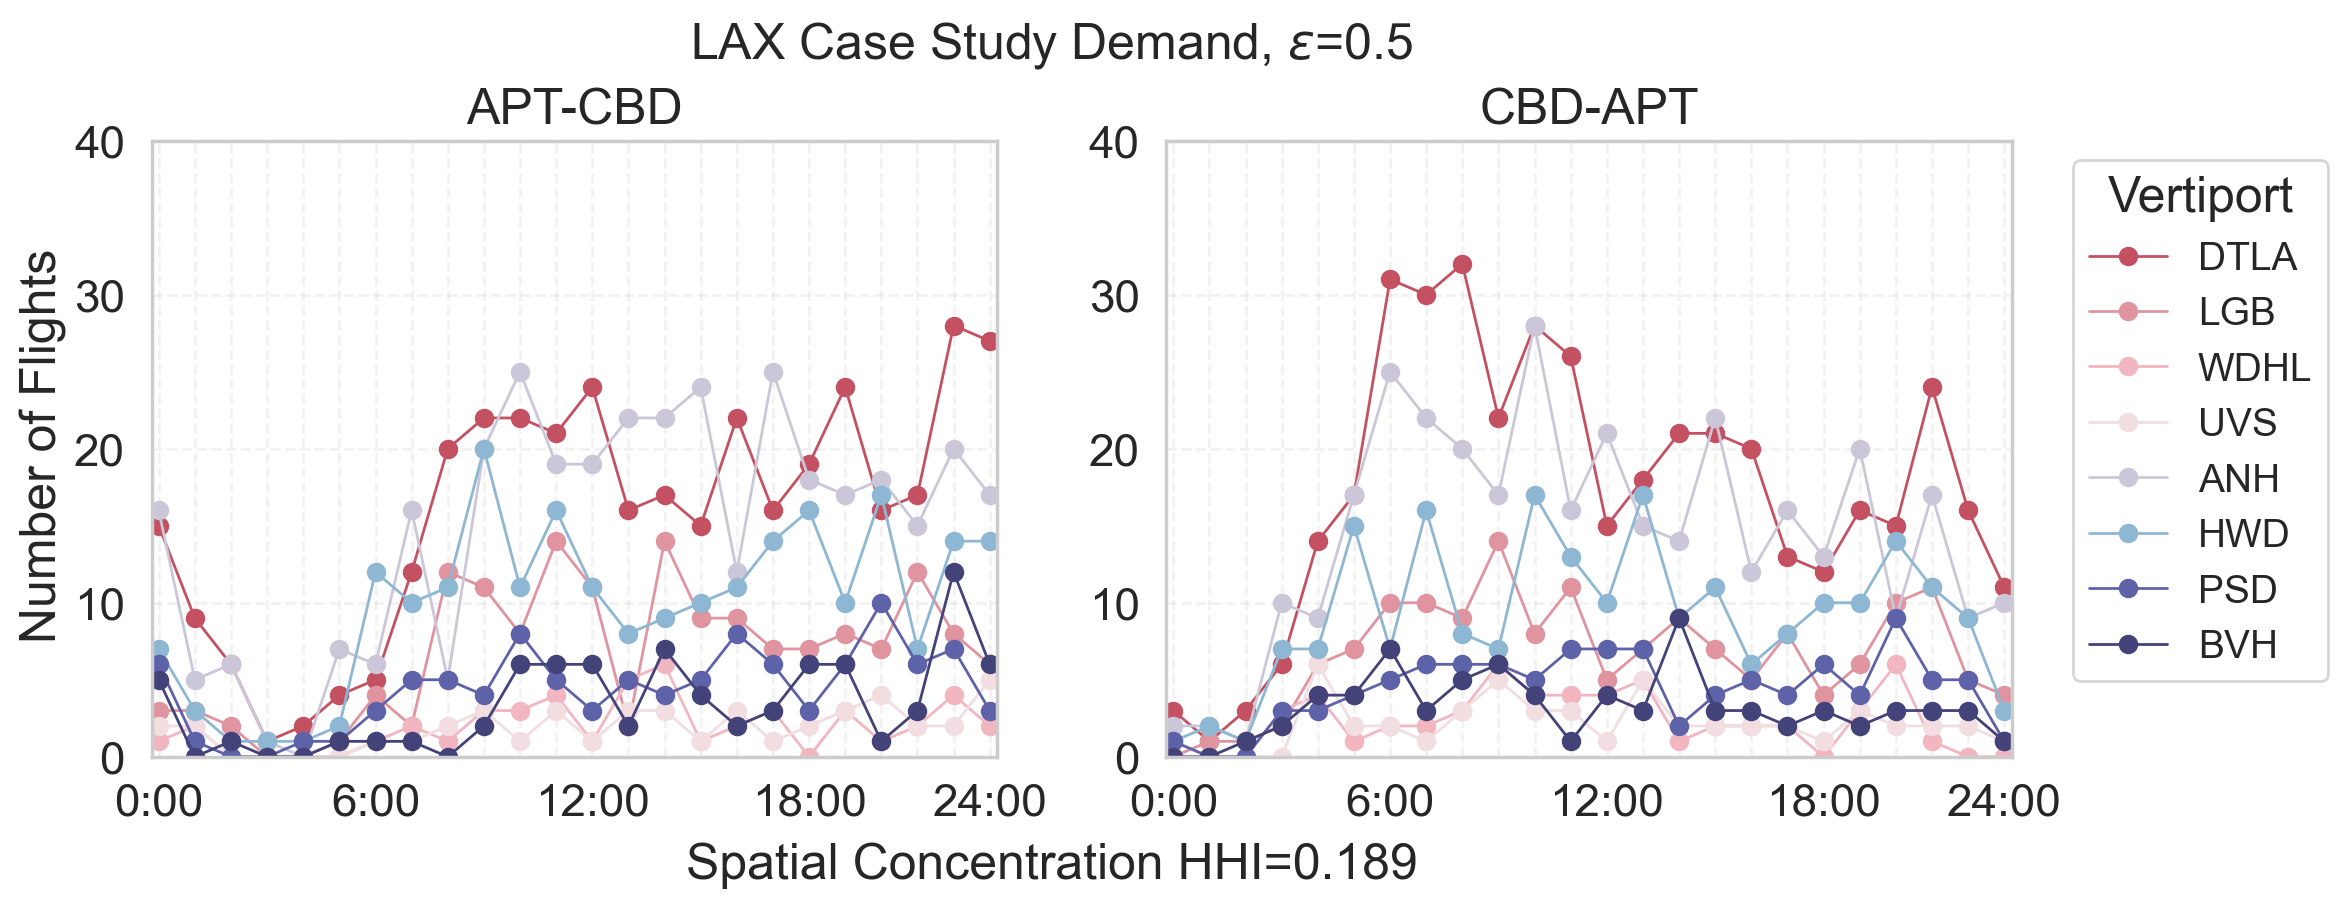

In [7]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2, dpi=200)
for i in range(1, demand_arr_for_viz.shape[1]):
    ax[0].plot(demand_arr_for_viz[0,i,:], color=color_palette[(i-1) % 10], 
               marker='o', label=vertiports[i], linewidth=1)
    ax[1].plot(demand_arr_for_viz[1,i,:], color=color_palette[(i-1) % 10],
               marker='o', label=vertiports[i], linewidth=1)

minorLocator = MultipleLocator(1)
for i in range(2):
    ax[i].set(xlabel='', ylabel='', 
                xticks=[0,6,12,18,24-1], xticklabels=['0:00', '6:00', '12:00', '18:00', '24:00'],
                ylim=(0,40),
                xlim=(-0.2,23.2));
    ax[i].xaxis.set_minor_locator(minorLocator)
    ax[i].grid(True, alpha=0.25, linestyle='--', which='both')
ax[0].set_title('APT-CBD')
ax[1].set_title('CBD-APT')
fig.text(0.5, 1, 'LAX Case Study Demand, $\epsilon$=0.5', ha='center', va='center')
fig.text(0.08, 0.5, 'Number of Flights', ha='center', va='center', rotation='vertical')
fig.text(0.5, -0.025, F'Spatial Concentration HHI={HHI(realized_p).round(3)}', ha='center', va='center')
plt.legend(title='Vertiport', bbox_to_anchor=(1.05, 1), loc='upper left');

#### Flight Parameters

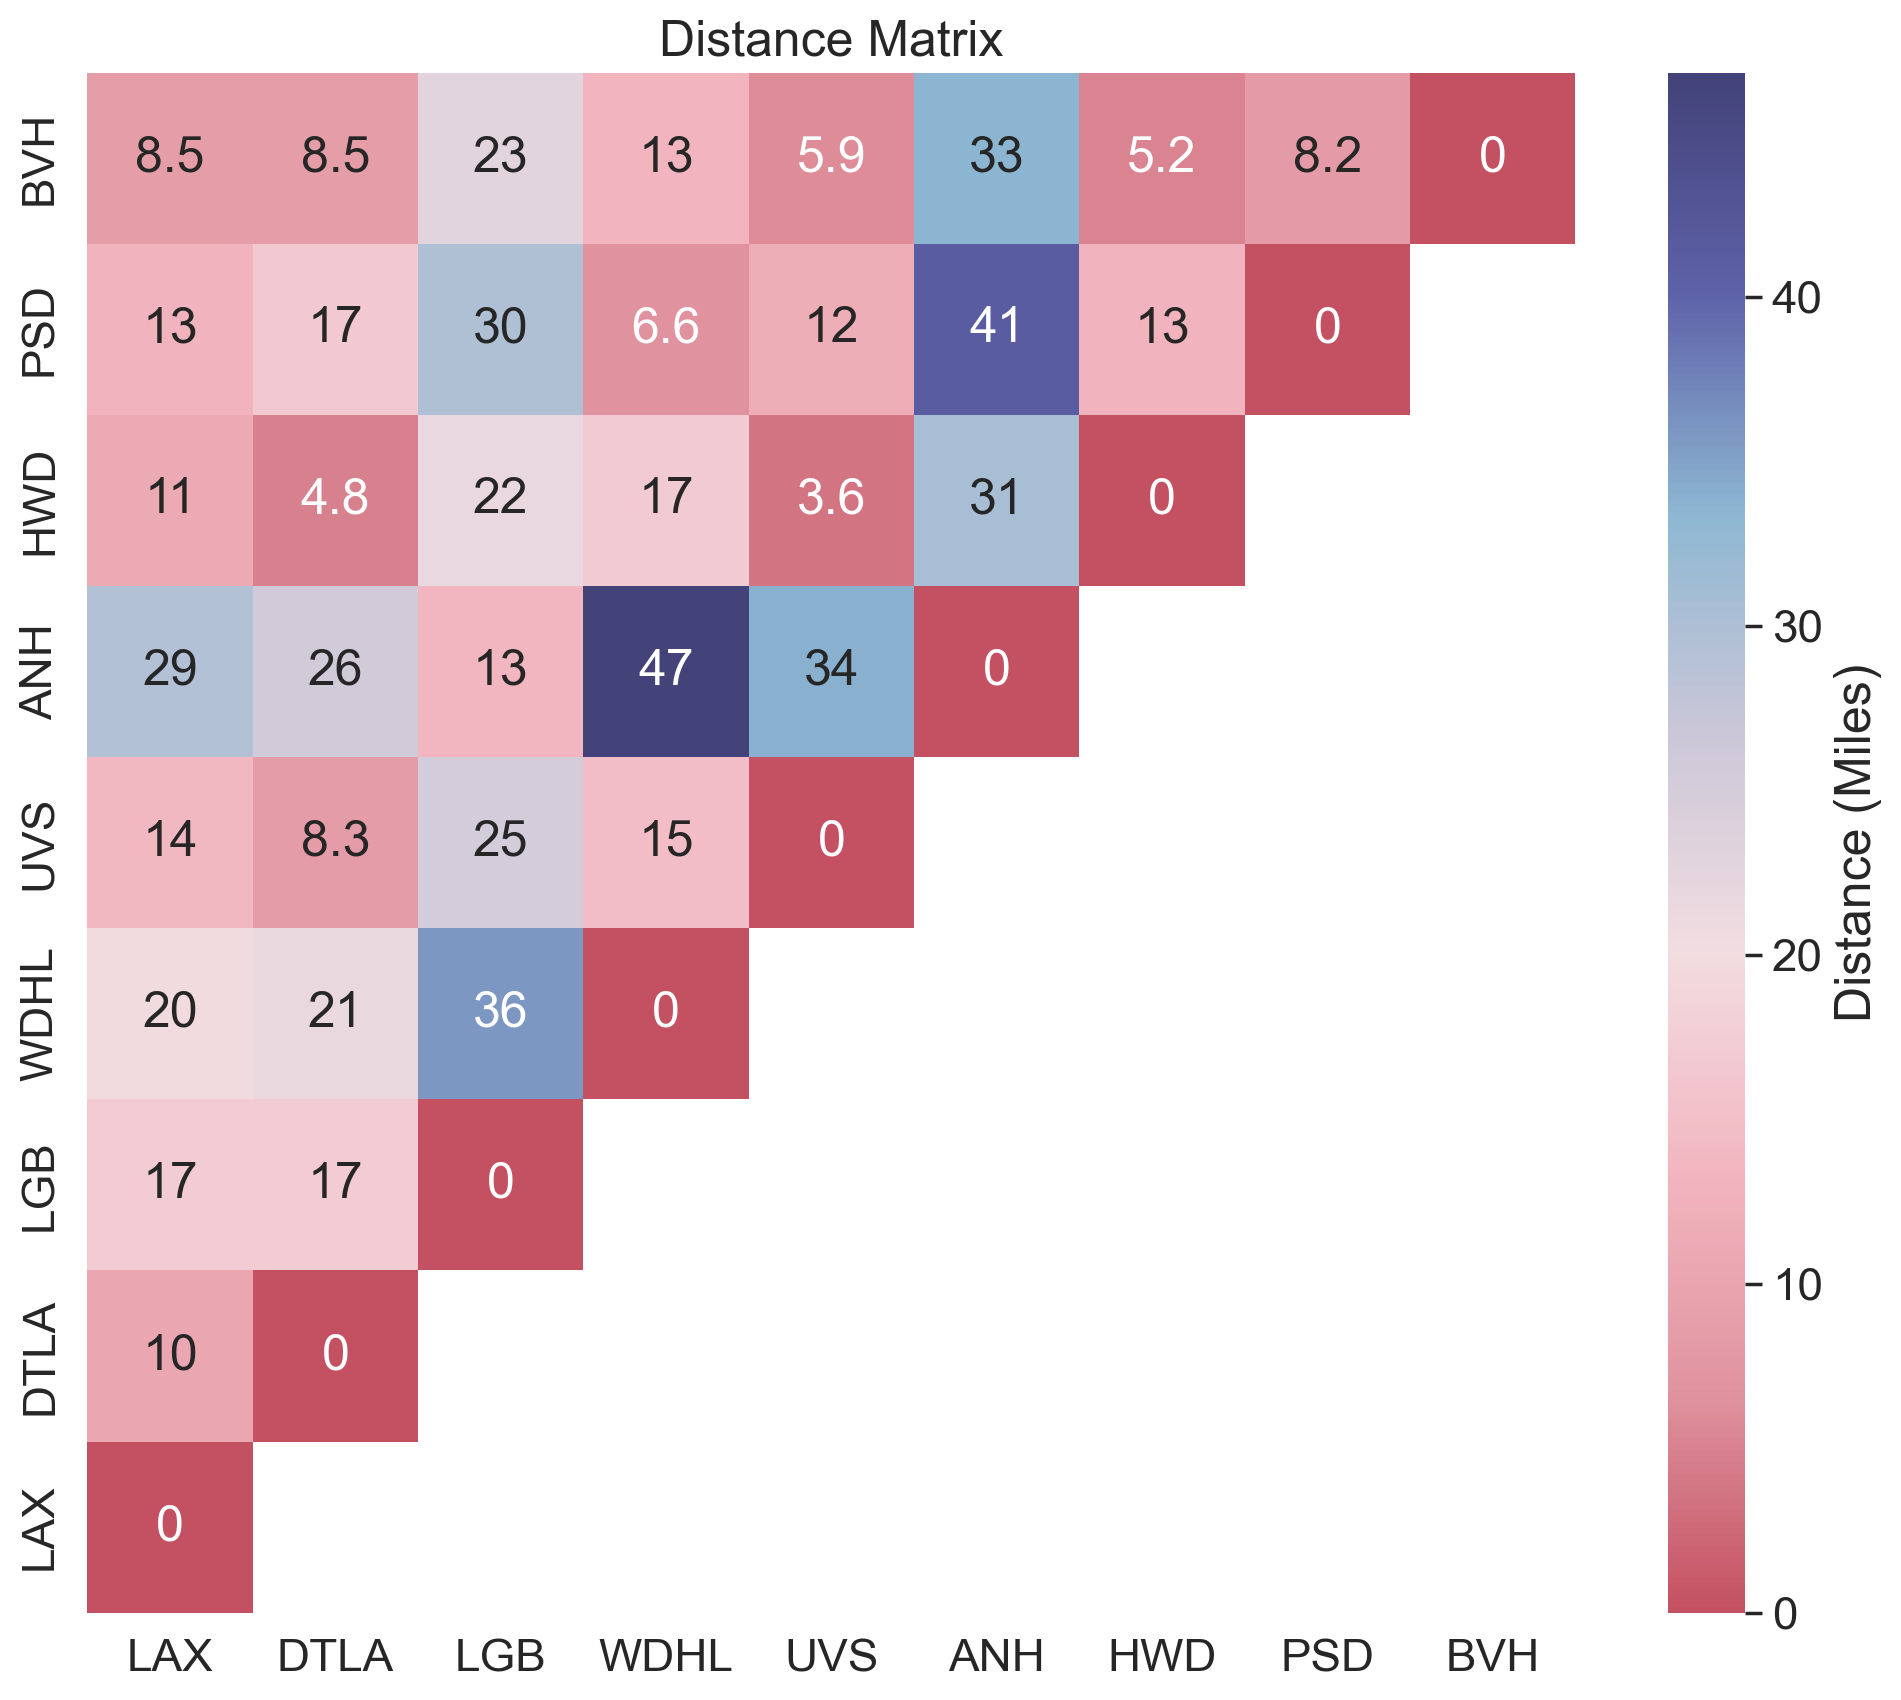

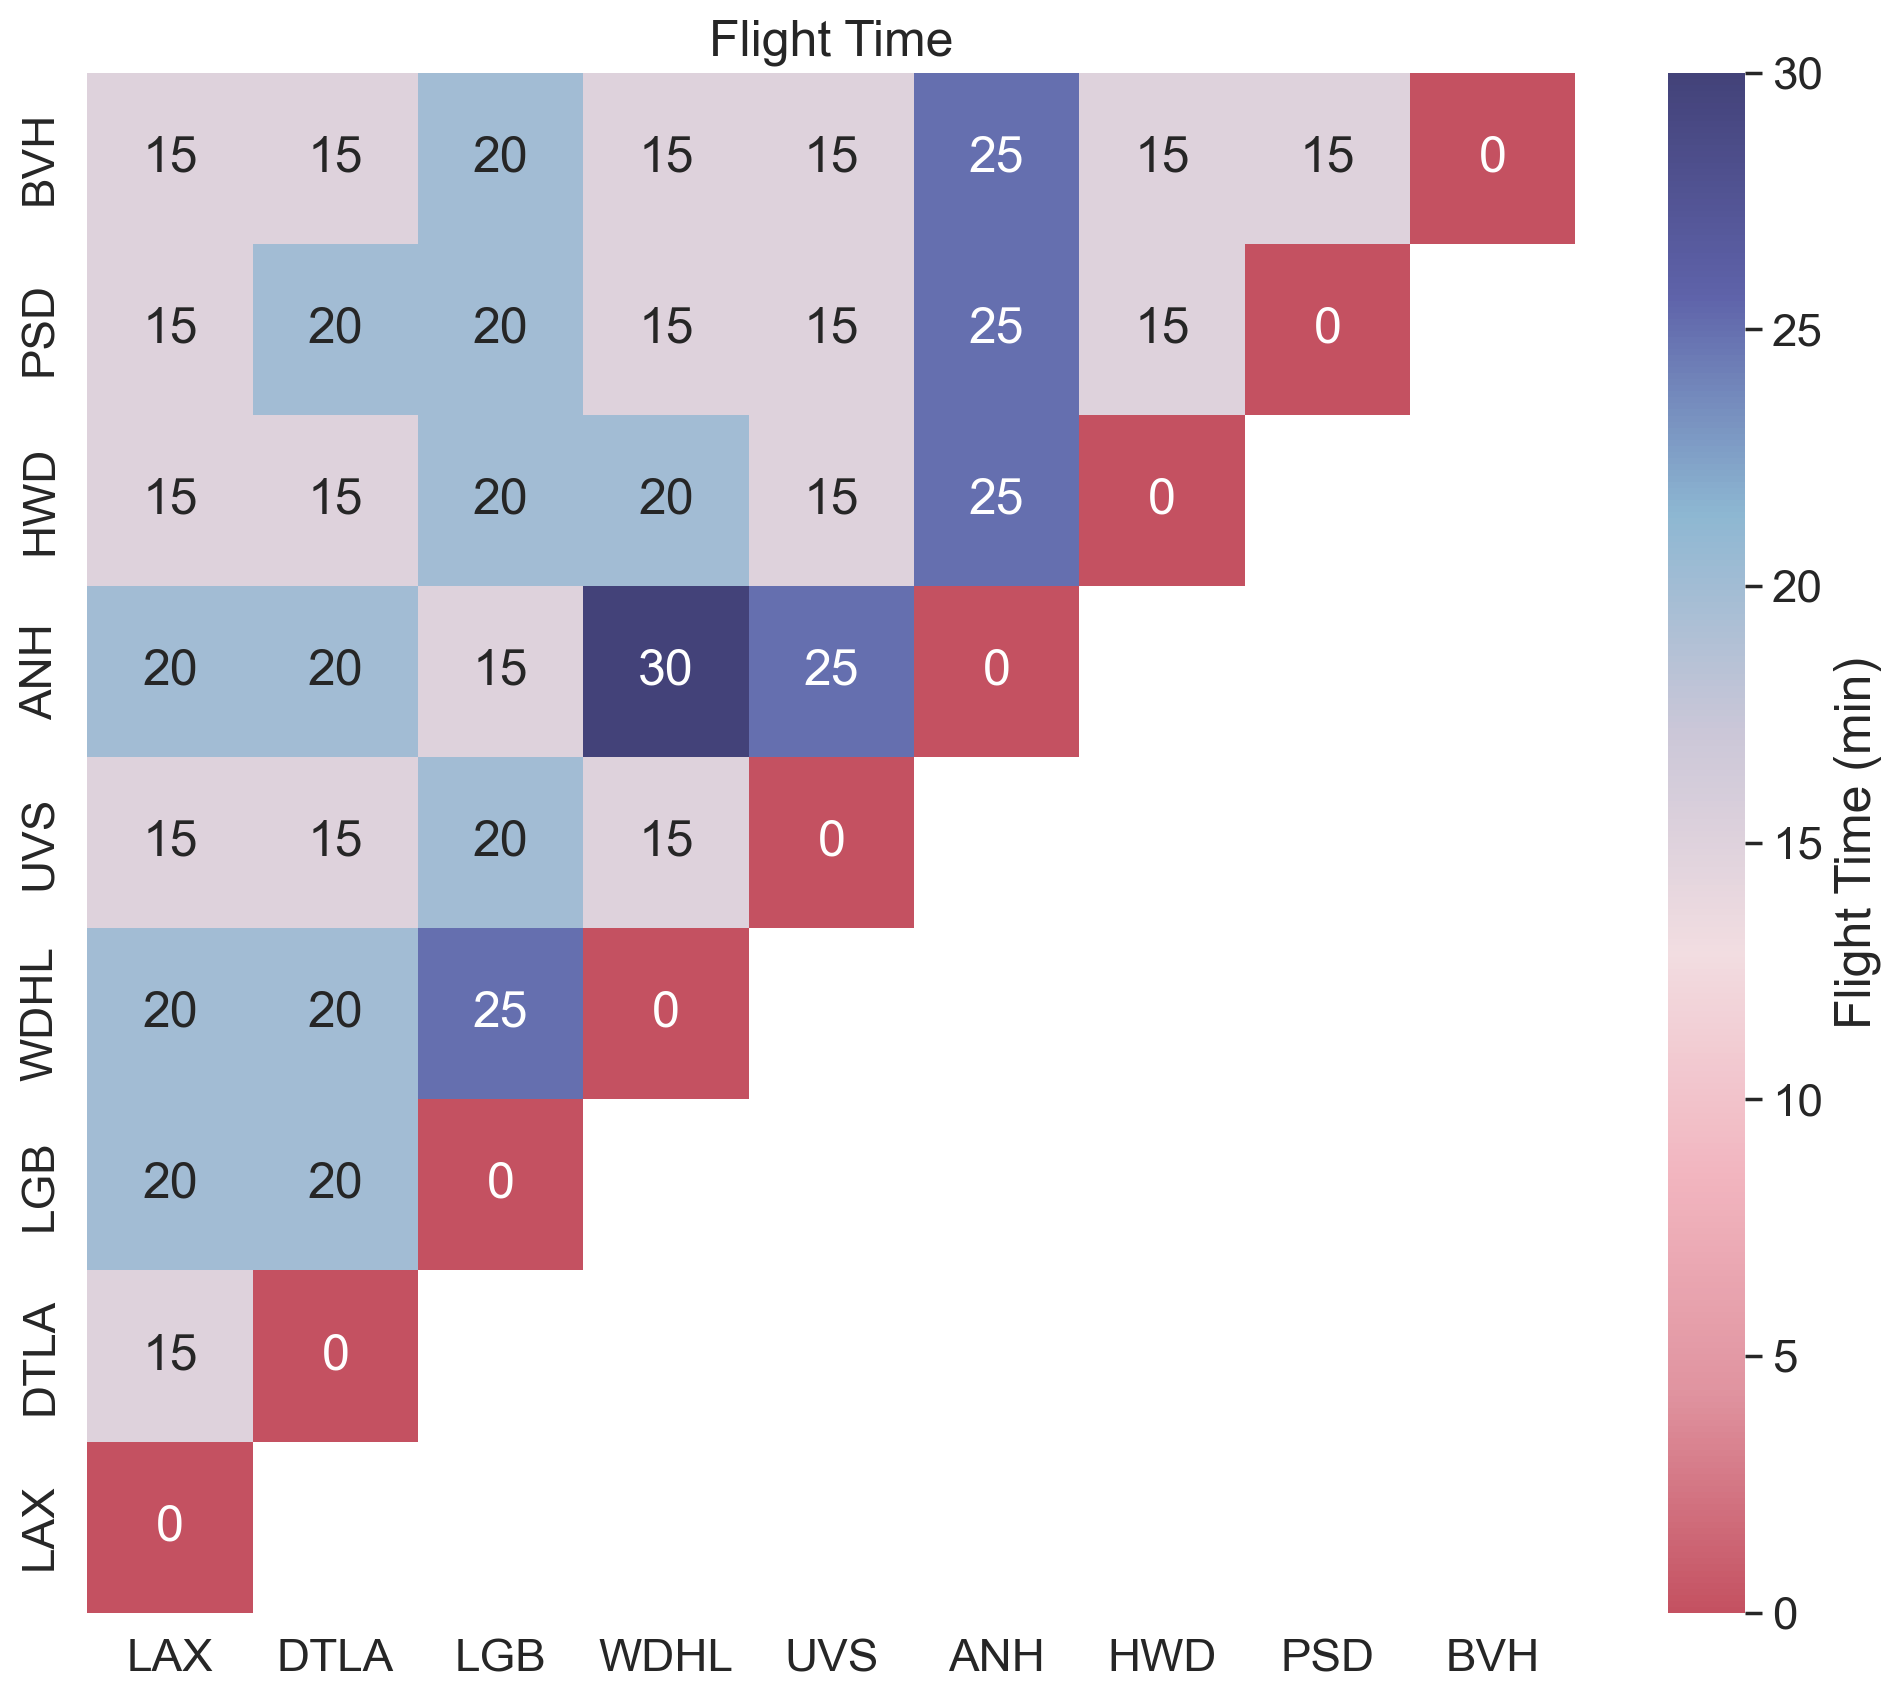

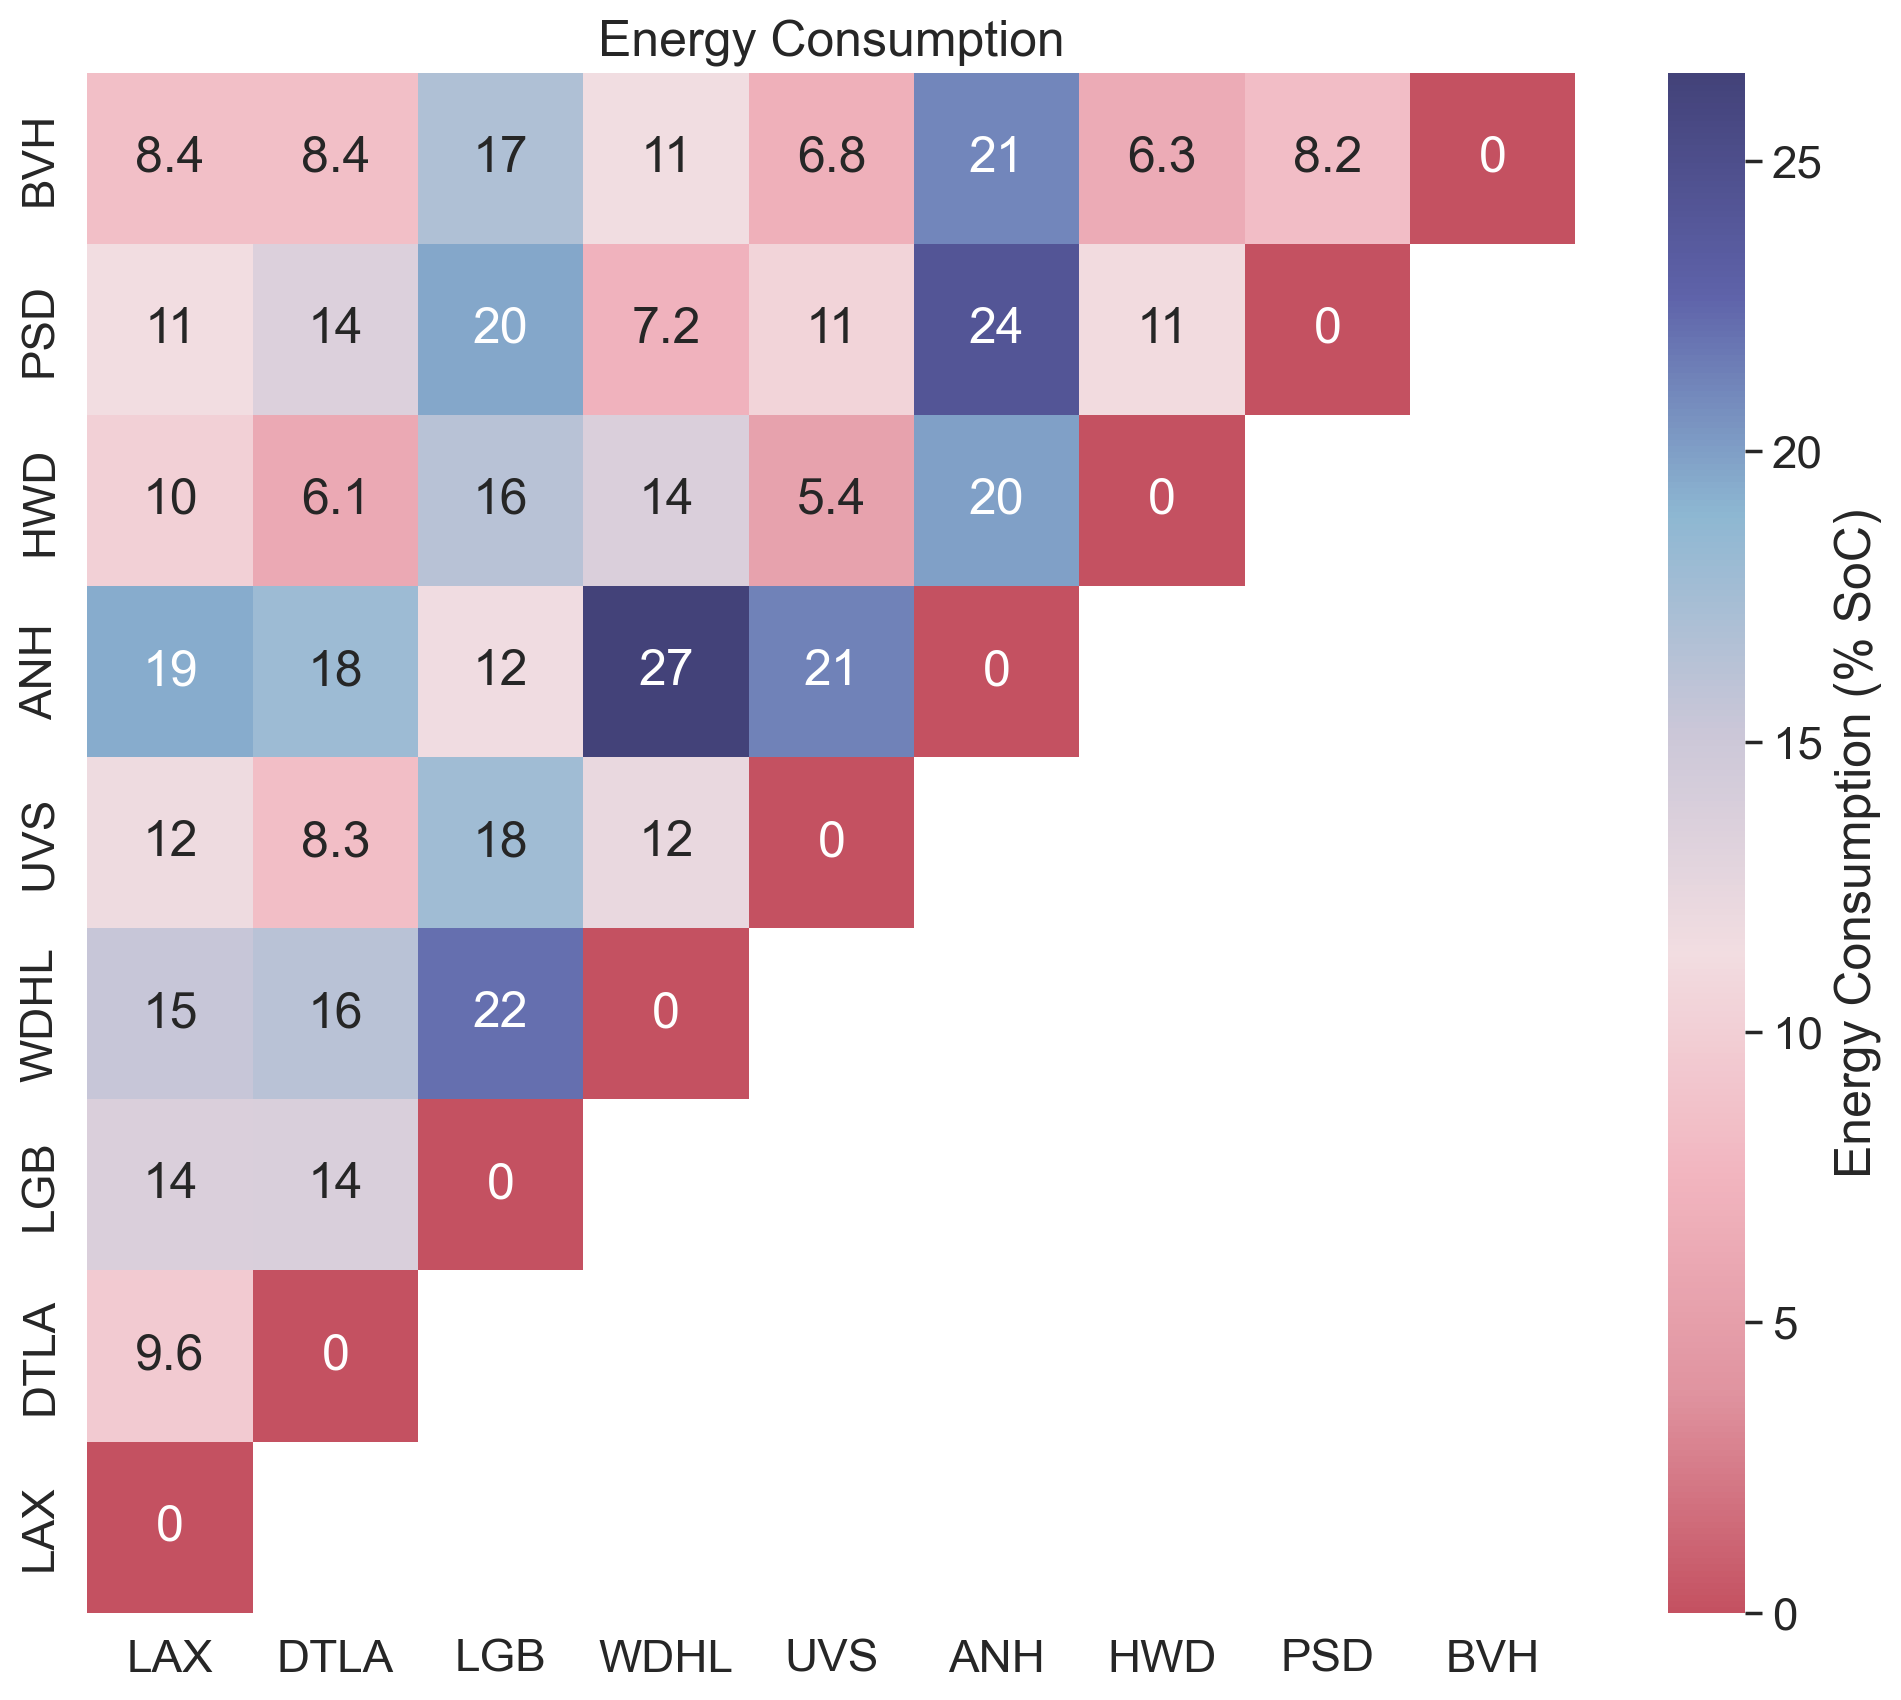

In [8]:
coordinates = np.array([(33.94417072663332, -118.40248449470265),
                        (34.043119432990345, -118.26720629762752),
                        (33.81606030845284, -118.15122129260827),
                        (34.17160155814583, -118.60525790222589),
                        (34.13843197335217, -118.35511311047983),
                        (33.812102161009804, -117.91897753216998),
                        (34.09174681098575, -118.32725521957076),
                        (34.08807589928915, -118.55063573741867),
                        (34.06666969690935, -118.4114352069469)])
                        
soc_transition_time = np.array([0.0129,0.0133,0.0137,0.0142,0.0147,
                        0.0153,0.0158,0.0166,0.0172,0.018,
                        0.0188,0.0197,0.0207,0.0219,0.0231,
                        0.0245,0.026,0.0278,0.03,0.0323,
                        0.0351,0.0384,0.0423,0.0472,0.0536,
                        0.0617,0.0726,0.0887,0.1136,0.1582,
                        0.2622,0.9278,])*60

distance_matrix = calculate_distances_in_meters(coordinates)
flight_time = np.zeros(shape=distance_matrix.shape)
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        distance = distance_matrix[i][j]
        cruise_speed = 180/12 # miles per 5 minutes
        if i != j:
            flight_time[i][j] = 2 + np.ceil(distance / cruise_speed)

energy_consumption = np.zeros(shape=distance_matrix.shape)
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        distance = distance_matrix[i][j]
        if i!= j:
            if distance <= 20:
                energy_consumption[i][j] = distance * 1 + 5
            else:
                energy_consumption[i][j] = 20 + (distance - 20) * 0.65 + 5
energy_consumption = energy_consumption / 160 * 100

charging_time = np.zeros(shape=distance_matrix.shape)
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        distance = distance_matrix[i][j]
        if i!= j:
            charging_time[i][j] = soc_transition_time[:int(np.ceil(energy_consumption[i][j]/2.5))].sum()
charging_time = charging_time.astype(int)


mask = np.triu(np.ones_like(distance_matrix, dtype=bool), k=1)
fig, ax = plt.subplots(dpi=200, figsize=(12,10))
sns.heatmap(distance_matrix, annot=True, cmap=cmap, ax=ax,
            cbar_kws={'label': 'Distance (Miles)'}, mask=mask)
yticklabels = vertiports[::-1]
ax.set(yticklabels=list(vertiport_dict.values()), 
        xticklabels=list(vertiport_dict.values()), 
        title='Distance Matrix');
ax.invert_yaxis()
plt.grid(False)

fig, ax = plt.subplots(dpi=200, figsize=(12,10))
sns.heatmap(flight_time*5, annot=True, cmap=cmap, ax=ax,
            cbar_kws={'label': 'Flight Time (min)'}, mask=mask)
yticklabels = vertiports[::-1]
ax.set(yticklabels=list(vertiport_dict.values()), 
        xticklabels=list(vertiport_dict.values()), 
        title='Flight Time');
ax.invert_yaxis()
plt.grid(False)

fig, ax = plt.subplots(dpi=200, figsize=(12,10))
sns.heatmap(energy_consumption, annot=True, cmap=cmap, ax=ax,
            cbar_kws={'label': 'Energy Consumption (% SoC)'}, mask=mask)
yticklabels = vertiports[::-1]
ax.set(yticklabels=list(vertiport_dict.values()), 
        xticklabels=list(vertiport_dict.values()), 
        title='Energy Consumption');
ax.invert_yaxis()
plt.grid(False)

# UB: The Assignment Problem

In [9]:
import model.topology
importlib.reload(model.topology)
from model.topology import AssignmentNetwork, FlightTask

## Build out the network and tasks

In [10]:
repurposing_time = flight_time + charging_time

all_tasks = []
idx = 0
for key, value in demand_dict.items():
    origin, destination, time = key
    for _ in range(value):
        all_tasks.append(FlightTask(f'{vertiports[origin]}_{vertiports[destination]}_{idx}', time, repurposing_time, origin, destination))
        idx += 1

all_tasks = sorted(all_tasks, key=lambda x: x.start_time)

In [11]:
network = AssignmentNetwork(all_tasks)
nodes, supply, edges, cost, c = network.populate_network()

## Solve the problem

In [15]:
m = Model("MCNF")

flow = m.addVars(edges, obj=cost, name="flow", lb=0)
for n in tqdm(nodes):
    m.addConstr(sum(flow[i, j] for i, j in edges if j == n) -
                sum(flow[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")

for edge in tqdm(edges):
    edge_source = edge[0]
    edge_target = edge[1]
    if len(edge_source) == 2 & len(edge_target) == 2:
        if edge_source[0] == edge_target[0]:
            if (edge_source[1] == 'start') & (edge_target[1] == 'finish'):
                m.addConstr(flow[edge_source, edge_target] == 1, f"flow_{edge_source}_to_{edge_target}")
    
m.setParam('OutputFlag', 0)                
m.optimize()
print('Optimal Fleetsize: %g' % m.objVal)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-29


100%|██████████| 3579462/3579462 [00:01<00:00, 3014121.00it/s]


Optimal Fleetsize: 175


In [16]:
with open('../output/star_network/network_flow_0714/assignment_ub.txt', 'w') as f:
    for v in m.getVars():
        f.write(f'{v.varName} = {v.x}\n')

# IP

In [136]:
import model.IP
importlib.reload(model.IP)
from model.IP import FleetSizeOptimizer

In [138]:
for i in tqdm(range(1, len(vertiports))):
    two_vertiport_demand = get_2_vertiport_demand(demand_dict, vertiport_index=i)
    ft = np.array([[0, flight_time[0,i]*5], [flight_time[i,0]*5, 0]])
    ec = np.array([[0, energy_consumption[0,i]], [energy_consumption[i,0], 0]])
    fs = FleetSizeOptimizer(ft, ec, two_vertiport_demand)
    fs.optimize(output_path=f'../output/star_network/network_flow_0714/IP/exp1_v{i}', verbose=False, optimality_gap=0.05)


100%|██████████| 8/8 [09:27<00:00, 71.00s/it] 


# LB: Linear Relaxation and Lagrangian Relaxation

In [10]:
import model.topology
import importlib
importlib.reload(model.topology)
from model.topology import AssignmentNetwork, FlightTask, ChargingNetwork

## Build out the network

In [11]:
od_matrix = np.array([[0,1,1,1,1,1,1,1,1],
                      [1,0,1,1,1,1,1,1,1],
                      [1,1,0,1,1,1,1,1,1],
                      [1,1,1,0,1,1,1,1,1],
                      [1,1,1,1,0,1,1,1,1],
                      [1,1,1,1,1,0,1,1,1],
                      [1,1,1,1,1,1,0,1,1],
                      [1,1,1,1,1,1,1,0,1],
                      [1,1,1,1,1,1,1,1,0]])
flight_time = flight_time.astype(int)
energy_consumption = np.ceil(energy_consumption / 2.5).astype(int)

In [13]:
network2 = ChargingNetwork(vertiports, flight_time, energy_consumption, od_matrix)
nodes, supply, edges, cost, c = network2.populate_network()

In [14]:
model_name = 'STAR_8_0721'

In [15]:
########## This is only ran once to generate the mps file ############

m = Model("LagrangianRelaxation")
# Create variables
var_keys = m.addVars(edges, name=lambda e: f"flow_{e[0]}_{e[1]}", lb=0)
# Create flow conservation constraints
m.setParam('Threads', 4)
for n in tqdm(nodes):
    m.addConstr(quicksum(var_keys[i, j] for i, j in edges if j == n) -
    quicksum(var_keys[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")
m.update()
m.write(f'../output/star_network/LR/{model_name}.mps')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-07
Set parameter Threads to value 4


100%|██████████| 87320/87320 [2:05:53<00:00, 11.56it/s]  


In [91]:
def get_flight_edges(i, model_param, flight_time=flight_time, energy_consumption=energy_consumption):
    K = 32
    v1, v2, t = i
    flight_time_ij = flight_time[v1, v2]
    soc_level_drop = int(energy_consumption[v1, v2])

    volume = quicksum(model_param[(v1, t, k), (v2, int(t+flight_time_ij), k-soc_level_drop)] for k in range(soc_level_drop, K+1))
    
    return volume

## Linear Relaxation

In [93]:
lm = gp.read(f'../output/star_network/LR/{model_name}.mps')

flow_vars = lm.getVars()
flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}

for i in demand_dict.keys():
    lm.addConstr(get_flight_edges(i, flow) >= demand_dict[i], name=f'demand_constraint_{i}')

objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
# lm.setParam('OutputFlag', 0)
lm.setObjective(objective, GRB.MINIMIZE)
lm.relax()
lm.optimize()
lm.objVal


Read MPS format model from file ../output/star_network/LR/STAR_8_0714.mps
Reading time = 0.50 seconds
LagrangianRelaxation: 87320 rows, 2041802 columns, 4083604 nonzeros
Derived model does not contain these changes.
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 89357 rows, 2041802 columns and 4141657 nonzeros
Model fingerprint: 0xf3ae05c6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 846 rows and 11807 columns
Presolve time: 1.91s
Presolved: 88511 rows, 2029995 columns, 4118043 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Elapsed ordering time = 5s
Elapsed ordering time = 8s
Elapsed ordering time = 10s
Ordering time: 13.89s

Barrier statistics:
 AA' NZ     

80.00000000000033

In [50]:
# Obtain dual price if needed

# dual_prices = {}
# for constr in lm.getConstrs():
#     if constr.ConstrName.startswith('demand_constraint'):
#         dual_prices[constr.ConstrName] = constr.Pi
# print("Dual prices:", dual_prices)
# dual_price = np.abs(np.array(list(dual_prices.values())))

# dual_price = {i: dual_price[idx] for idx, i in enumerate(flight_demand.keys())}
# with open('../output/star_network/LR/dual_prices.pkl', 'wb') as f:
#     pickle.dump(dual_price, f)

## Lagrangian Relaxation

In [33]:
import model.LR
importlib.reload(model.LR)
from model.LR import LagrangianRelaxedFleetSize as LRFS
model_name = 'STAR_8_0714'

In [35]:
optimizer = LRFS(model_path = f'../output/star_network/LR/{model_name}.mps',
                 edges = edges,
                 cost = c, 
                 flight_time = flight_time,
                 energy_consumption = energy_consumption,
                 flight_demand=demand_dict)

In [36]:
# Solve the problem with lagrangian relaxation
optimizer.solve(path='../output/star_network/network_flow_0714/exp1_lr.pkl',
                max_iter=1000)

Iteration: 1 Dual OFV:  11168.0
Iteration: 2 Dual OFV:  10780.0
Iteration: 3 Dual OFV:  10384.000000000002


### Set `load_init` to `True` if would like to resume a previous run

In [48]:
optimizer.solve(path='../output/star_network/LR/0710_dual_init.pkl',
                load_init=True, 
                max_iter=3)

Loading values from the previous run
Number of existing iterations:  3
Iteration: 4 Dual OFV:  7544.000000000001
Iteration: 5 Dual OFV:  6984.0
Iteration: 6 Dual OFV:  6512.000000000001
